# 세미3 프로젝트 

### Subject - Loan Prediction Based on Customer Behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 연속적 print, output clear
## source : display(target), clear_output(wait=True)
from IPython.display import clear_output

#Console Prograss Bar
from tqdm import tqdm, trange, tqdm_notebook

from sklearn import preprocessing, model_selection
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

import os
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.pipeline import Pipeline




#from imblearn.combine import SMOTETomek,SMOTEENN

## 01. Function
1.1 BI Chart Draw

In [10]:
def fn_countplot(p_df, p_x_column, p_rotation='0', p_figsize=(15,5) ):
    plt.figure(figsize=p_figsize)
    plt.xticks(rotation=p_rotation)
    sns.countplot(x=p_x_column, data=p_df)
    plt.show()
    
def fn_heatmap(p_df):
    plt.figure(figsize=(10, 10))
    sns.heatmap(p_df, cbar=True, square=True, fmt='.5f', annot=True, annot_kws={'size': 8}, cmap='YlGnBu')
    plt.plot()

def fn_pie(p_df):
    plt.pie(p_df, explode=[0.05, 0.1], labels=['Non-Defaulter', 'Defaulter'], radius=1.5, autopct='%1.1f%%',  shadow=True)
    plt.show()
    
def fn_auc(p_fpr, p_tpr):
    plt.style.use('fivethirtyeight') 
    fig, ax = plt.subplots() 
    fig.set_size_inches(4.8, 5) 
    ax.step(fpr, tpr, 'gray') 
    ax.fill_between(p_fpr, p_tpr, 0, color='skyblue', alpha=0.8) 
    ax.set_xlabel('False Positive Rate') 
    ax.set_ylabel('True Positive Rate') 
    ax.set_facecolor('xkcd:white') 
    plt.show()
    
#특성 중요도 수평 막대그래프
def fn_feature_horizontal_graph(p_model, p_np_data, p_df_x_train, p_numeric_features, p_cat_features):
    trans_features = []
    
    trans_features = p_numeric_features
    
    for f_col in p_cat_features:
        for i in range(p_df_x_train.groupby(f_col)[f_col].count().groupby(f_col).count().sum()):
            trans_features.append(f_col + '_' + str(i))
    
    plt.figure(figsize=(20,40))
    n_features = p_np_data.data.shape[1]
    plt.barh(range(n_features), p_model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),trans_features)
    plt.xlabel("Features Importances")
    plt.ylabel("Features")
    plt.ylim(-1,n_features)
    plt.show()
    
def drow_barplot(x_data, y_data, x_name, y_name, xtick, graph_title, size=(20,10)):
    plt.figure(figsize=size)
    sns.barplot(x=x_data,y=y_data)
    plt.xticks(rotation=xtick)
    plt.xlabel(x_name, fontsize=16)
    plt.ylabel(y_name, fontsize=16)
    plt.title(graph_title, fontsize=18)
    plt.show()

1.2 Label & Ordinal Encoder

In [3]:
def fn_encoder(p_df):
    
    df_return = p_df
    
    features_cat    = []
    
    for f_col in p_df:
        if p_df[f_col].dtype == 'object':
            
            cat_cnt = p_df.groupby(f_col)[f_col].count().groupby(f_col).count().sum()
            
            if cat_cnt < 10:
                print('#label# \t\t col_name :',f_col, '\t\t cnt : ', cat_cnt)
                ## 갯수가 적으면 label 인코더로..
                label_encoder    = preprocessing.LabelEncoder()
                df_return[f_col] = label_encoder.fit_transform(p_df[f_col])
            
            else:
                print('#Ordinal#\t\t col_name :',f_col, '\t\t cnt : ', cat_cnt)
                features_cat.append(f_col)
        
    
    ## ordinal_encoder 적용
    if(len(features_cat) > 0):
        ordinal_encoder = preprocessing.OrdinalEncoder()
        df_return.loc[:, features_cat] = ordinal_encoder.fit_transform(df_return.loc[:, features_cat])

    return df_return

## 02. 전처리 Proc

2.1 Data Load

In [4]:
import scipy as sp
from scipy import stats # statistics

In [3]:
df_loan_train = pd.read_excel("./Dataset/Training Data.xlsx")
df_loan_test = pd.read_excel("./Dataset/Test Data.xlsx")

del df_loan_train['Id']
del df_loan_test['ID']

In [4]:
#income 소득
#Age    나이
#Experience 경험
#Married/Single 기혼/미혼
#House_Ownership 집_소유권
#Car_Ownership 차 소유권
#Prefession 직업
#City 도시
#state 주(도심)
#current_job_yrs 현재 직업경력
#current_house_yrs 현재 집 소유 기간
#Risk_flag Target
display(df_loan_train.head(2))

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0


In [7]:
df_loan_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Income              252000 non-null  int64 
 1   Age                 252000 non-null  int64 
 2   Experience          252000 non-null  int64 
 3   Married/Single      252000 non-null  object
 4   House_Ownership     252000 non-null  object
 5   Car_Ownership       252000 non-null  object
 6   Profession          252000 non-null  object
 7   CITY                252000 non-null  object
 8   STATE               252000 non-null  object
 9   CURRENT_JOB_YRS     252000 non-null  int64 
 10  CURRENT_HOUSE_YRS   252000 non-null  int64 
 11  Risk_Flag           252000 non-null  int64 
 12  changed_profession  252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


2.1.1 Data Chart Draw

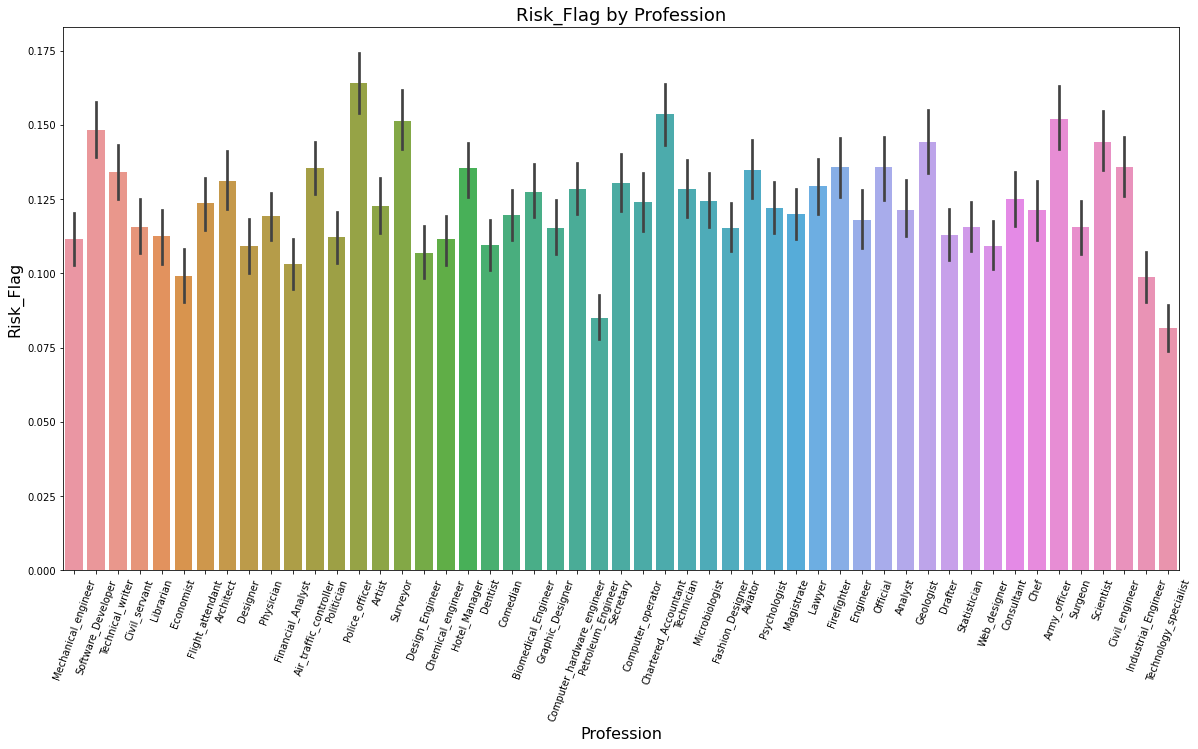

In [18]:
drow_barplot(df_loan_train['Profession'],df_loan_train['Risk_Flag'],
             'Profession','Risk_Flag',70,'Risk_Flag by Profession')

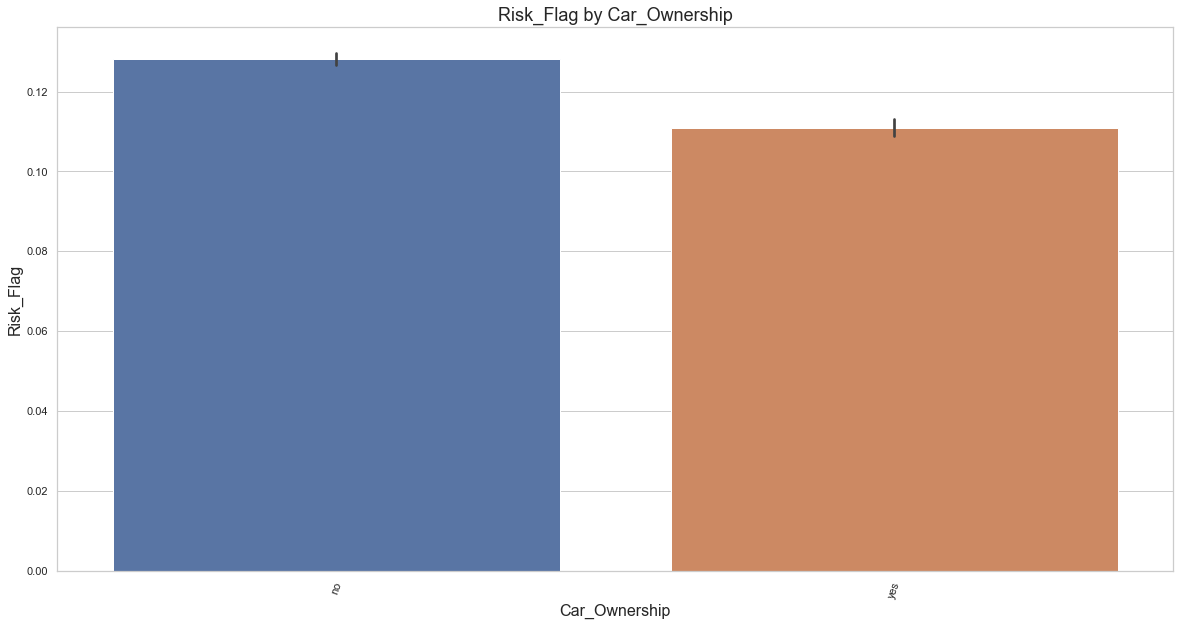

In [41]:
drow_barplot(df_loan_train['Car_Ownership'],df_loan_train['Risk_Flag'],
             'Car_Ownership','Risk_Flag',70,'Risk_Flag by Car_Ownership')

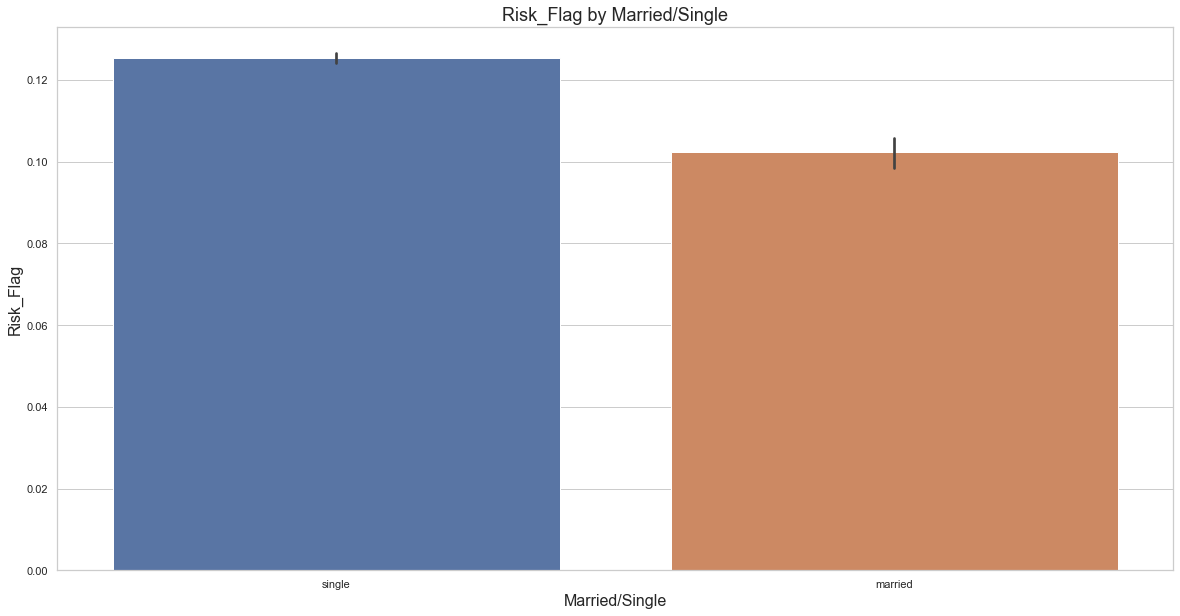

In [42]:
drow_barplot(df_loan_train['Married/Single'],df_loan_train['Risk_Flag'],
             'Married/Single','Risk_Flag',0,'Risk_Flag by Married/Single')

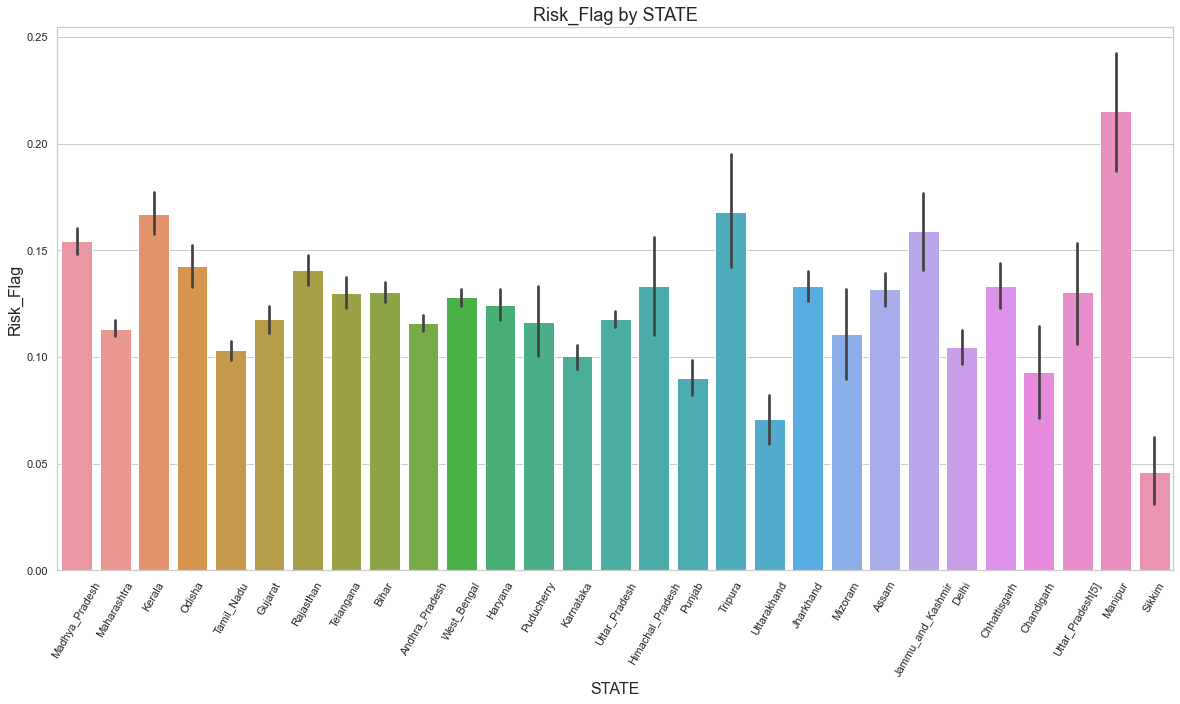

In [44]:
drow_barplot(df_loan_train['STATE'],df_loan_train['Risk_Flag'],
             'STATE','Risk_Flag',60,'Risk_Flag by STATE')

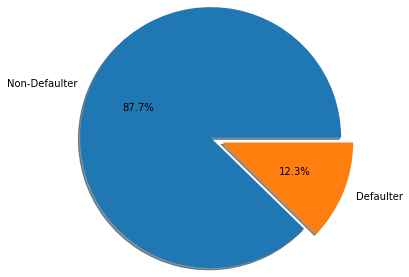

In [8]:
cnt_risk_flag = df_loan_train.groupby('Risk_Flag')['Risk_Flag'].count()
fn_pie(cnt_risk_flag)

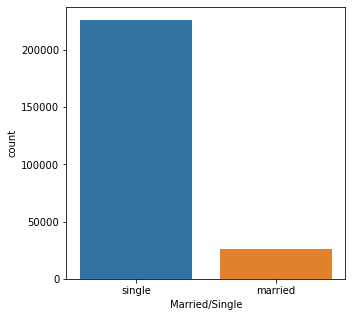

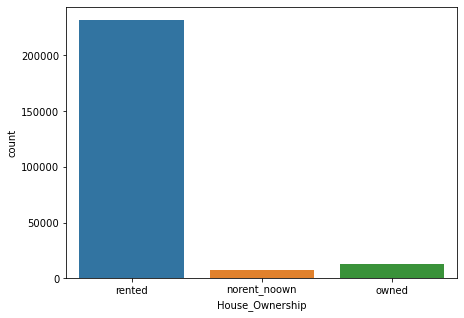

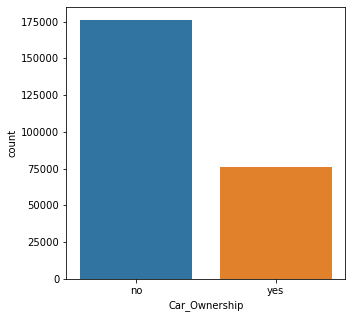

In [9]:
fn_countplot(df_loan_train, 'Married/Single', '0', (5,5))
fn_countplot(df_loan_train, 'House_Ownership', '0', (7,5))
fn_countplot(df_loan_train, 'Car_Ownership', '0', (5,5)) 

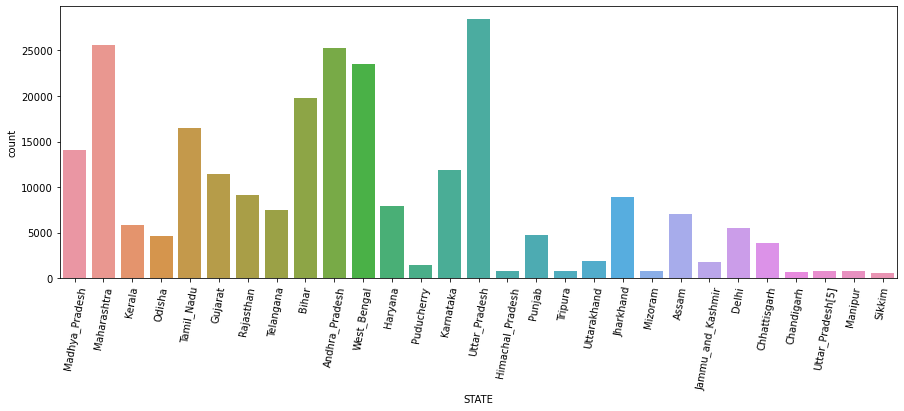

In [12]:
fn_countplot(df_loan_train, 'STATE', '80')

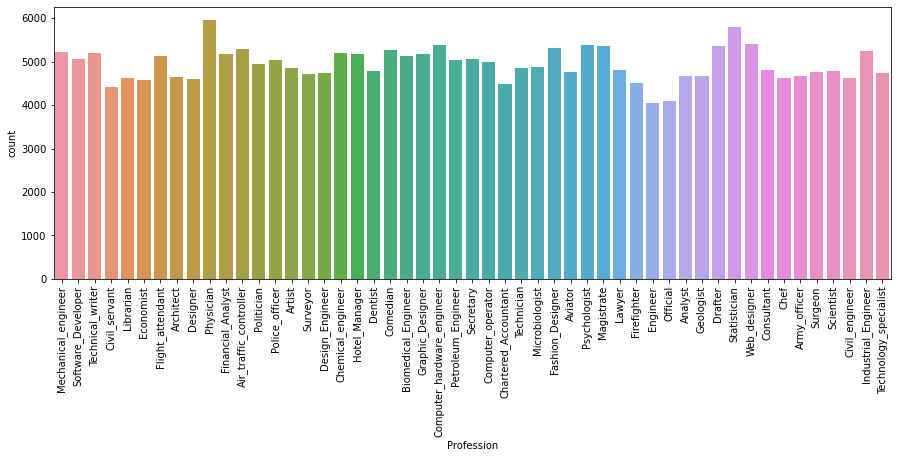

In [13]:
fn_countplot(df_loan_train, 'Profession', '90')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52285 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 52285 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50145 missing from current f

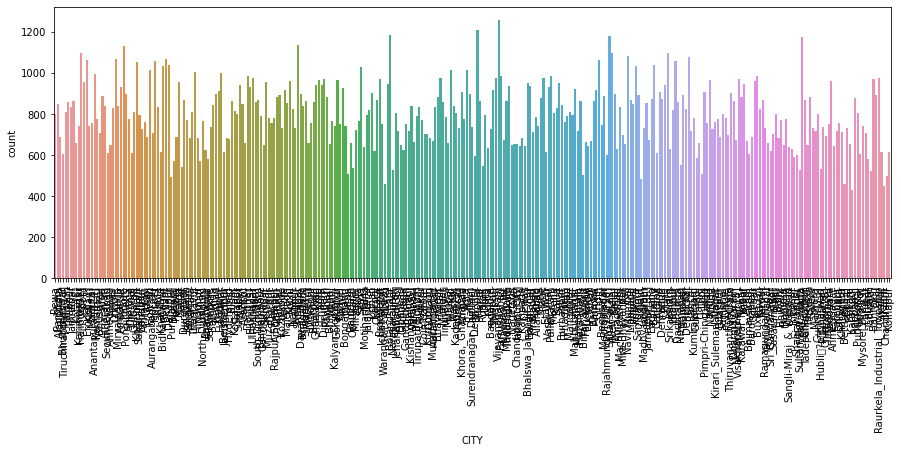

In [14]:
fn_countplot(df_loan_train, 'CITY', '90')

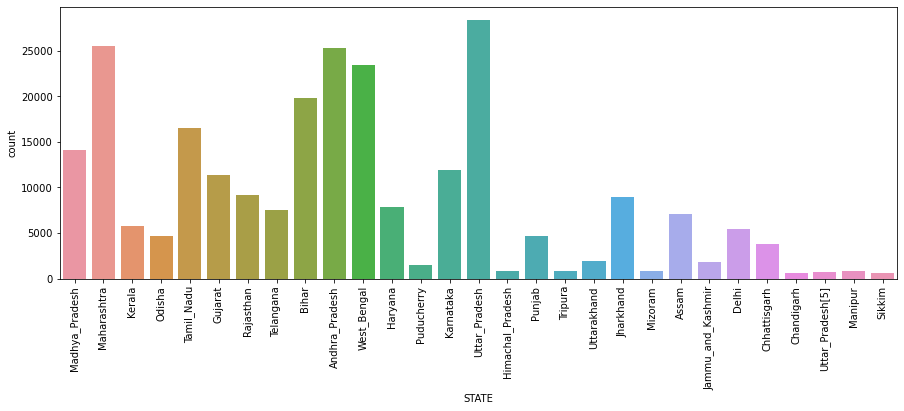

In [15]:
fn_countplot(df_loan_train, 'STATE', '90')

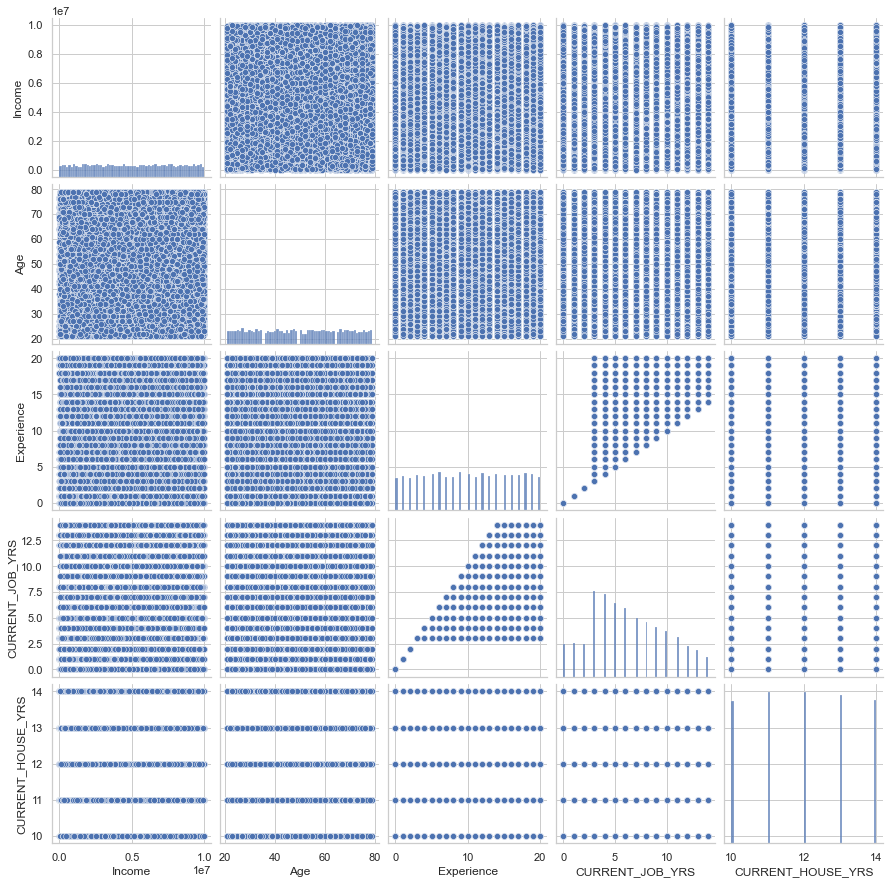

In [32]:
# 시각화 라이브러리를 이용한 피처간의 산포도를 출력
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df_loan_train[['Income','Age','Experience',
                    'CURRENT_JOB_YRS','CURRENT_HOUSE_YRS']], height=2.5)
plt.show()

In [30]:
corr = df_loan_train[['Experience', 'CURRENT_JOB_YRS']].corr(method = 'pearson')
print(corr)

                 Experience  CURRENT_JOB_YRS
Experience         1.000000         0.646098
CURRENT_JOB_YRS    0.646098         1.000000


2.2 Processing

2.2.1 Proc Encoder|

In [ ]:
#새로운 칼럼 만들기
df_loan_train['changed_profession'] = df_loan_train['Experience'] - df_loan_train['CURRENT_JOB_YRS']
df_loan_train['changed_profession'] = df_loan_train['changed_profession'].apply(lambda x:0 if (x == 0) else 1)

df_loan_test['changed_profession'] = df_loan_test['Experience'] - df_loan_test['CURRENT_JOB_YRS']
df_loan_test['changed_profession'] = df_loan_test['changed_profession'].apply(lambda x:0 if (x == 0) else 1)

In [59]:
del df_loan_train['CITY']
del df_loan_test['CITY']

In [60]:
# Constructing a heatmap to understand the correlation
rtn_data = fn_encoder(df_loan_train)
rtn_data2 = fn_encoder(df_loan_test)

#label# 		 col_name : Married/Single 		 cnt :  2
#label# 		 col_name : House_Ownership 		 cnt :  3
#label# 		 col_name : Car_Ownership 		 cnt :  2
#Ordinal#		 col_name : Profession 		 cnt :  51
#Ordinal#		 col_name : STATE 		 cnt :  29
#label# 		 col_name : Married/Single 		 cnt :  2
#label# 		 col_name : House_Ownership 		 cnt :  3
#label# 		 col_name : Car_Ownership 		 cnt :  2
#Ordinal#		 col_name : Profession 		 cnt :  51
#Ordinal#		 col_name : STATE 		 cnt :  29


In [62]:
rtn_data.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,changed_profession
0,1303834,23,3,1,2,0,33.0,13.0,3,13,0,0
1,7574516,40,10,1,2,0,43.0,14.0,9,13,0,1
2,3991815,66,4,0,2,0,47.0,12.0,4,10,0,0
3,6256451,41,2,1,2,1,43.0,17.0,2,12,1,0
4,5768871,47,11,1,2,0,11.0,22.0,3,14,1,1


In [19]:
rtn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Income              252000 non-null  int64  
 1   Age                 252000 non-null  int64  
 2   Experience          252000 non-null  int64  
 3   Married/Single      252000 non-null  int32  
 4   House_Ownership     252000 non-null  int32  
 5   Car_Ownership       252000 non-null  int32  
 6   Profession          252000 non-null  float64
 7   STATE               252000 non-null  float64
 8   CURRENT_JOB_YRS     252000 non-null  int64  
 9   CURRENT_HOUSE_YRS   252000 non-null  int64  
 10  Risk_Flag           252000 non-null  int64  
 11  changed_profession  252000 non-null  int64  
dtypes: float64(2), int32(3), int64(7)
memory usage: 20.2 MB


In [20]:
## 상관계수 분석
# 반응변수 Risk_Flag의 class 불균형이 너무 심하여 상관계수를 보다 명확히 따져보기엔 어려울 것으로 판단.
rtn_data.corr()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,changed_profession
Income,1.000000,-0.000652,0.006422,0.002682,0.016433,0.004068,0.000725,-0.004067,0.007045,-0.002397,-0.003091,0.017193
Age,-0.000652,1.000000,-0.001118,-0.005323,-0.009820,0.009395,-0.008551,-0.004985,0.002154,-0.020134,-0.021809,-0.007257
Experience,0.006422,-0.001118,1.000000,-0.001752,-0.007912,0.007519,0.000975,-0.001251,0.646098,0.019309,-0.034523,0.764297
Married/Single,0.002682,-0.005323,-0.001752,1.000000,-0.022501,0.001206,-0.007534,-0.009477,0.004251,-0.007539,0.021092,0.001794
House_Ownership,0.016433,-0.009820,-0.007912,-0.022501,1.000000,-0.001233,0.001242,-0.007792,-0.009790,-0.005618,0.023622,0.000098
Car_Ownership,0.004068,0.009395,0.007519,0.001206,-0.001233,1.000000,0.011887,0.026000,0.011099,0.000251,-0.024036,0.011725
Profession,0.000725,-0.008551,0.000975,-0.007534,0.001242,0.011887,1.000000,0.001557,-0.004536,0.001954,-0.004900,0.009875
STATE,-0.004067,-0.004985,-0.001251,-0.009477,-0.007792,0.026000,0.001557,1.000000,0.008745,0.007281,-0.003401,-0.008728
CURRENT_JOB_YRS,0.007045,0.002154,0.646098,0.004251,-0.009790,0.011099,-0.004536,0.008745,1.000000,0.005372,-0.016942,0.318987
CURRENT_HOUSE_YRS,-0.002397,-0.020134,0.019309,-0.007539,-0.005618,0.000251,0.001954,0.007281,0.005372,1.000000,-0.004375,0.018366


2.2.2 Processing Data Chart Draw

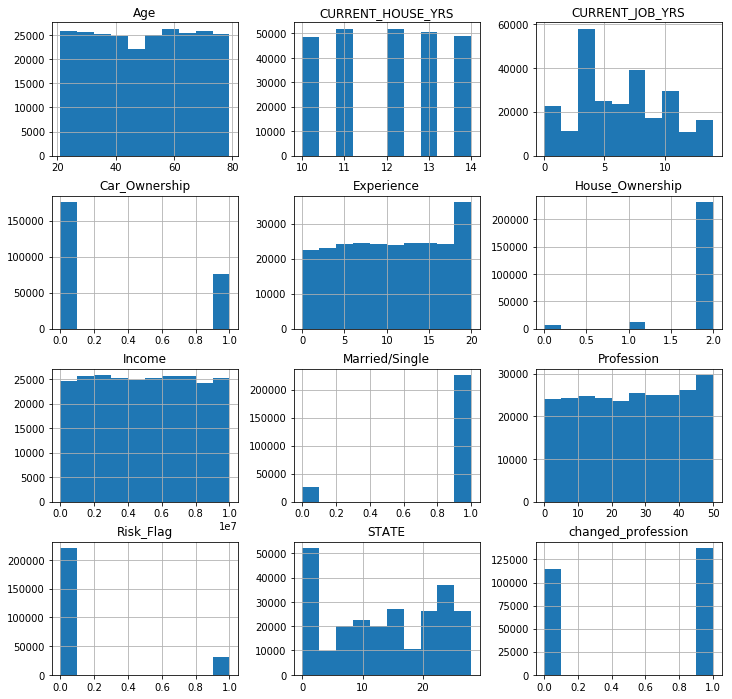

In [66]:
rtn_data.hist(figsize=(12, 12))
plt.show()

2.2.3 x data, y data 분리

In [21]:
y_data = rtn_data['Risk_Flag']
x_data = rtn_data.drop('Risk_Flag', axis=1)

In [22]:
for col in x_data:
    x_data[col] = x_data[col].astype(int)

2.2.4 Train - Test Split 처리 (0.2, Random = 0)

In [23]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=0)

2.2.5 Data(x_train, y_train) Under Sampling

No. of samples after under-Sampling: (74565, 11)
No. of samples after under-Sampling: (74565,)


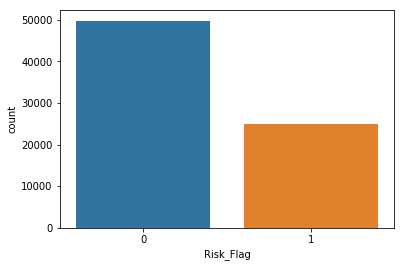

In [70]:
# Under Sampling
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=0)
x_under,y_under = under_sampler.fit_resample(x_train,y_train)

print("No. of samples after under-Sampling:", x_under.shape)
print("No. of samples after under-Sampling:", y_under.shape)
sns.countplot(x = y_under)

2.2.6 Data(x_under, y_under) Over Sampling

No. of samples after Over-Sampling: (99420, 11)
No. of samples after Over-Sampling: (99420,)


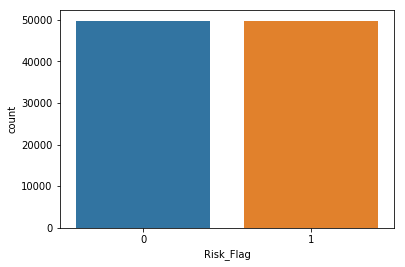

In [71]:
# Over Sampling
over_sampler = SMOTE(random_state=42, n_jobs=-1, sampling_strategy=1)
x_over,y_over = over_sampler.fit_resample(x_under,y_under)
print("No. of samples after Over-Sampling:",x_over.shape)
print("No. of samples after Over-Sampling:",y_over.shape)
sns.countplot(x = y_over)

In [72]:
display(x_over.shape)
display(y_over.shape)

(99420, 11)

(99420,)

In [77]:
y_over.value_counts()

1    49710
0    49710
Name: Risk_Flag, dtype: int64

In [364]:
x_over = x_over.join(y_over)
x_test = x_test.join(y_test)

In [366]:
x_over.to_csv('x_train.csv', encoding='euc-kr', index = False)
x_test.to_csv('x_test.csv', encoding='euc-kr', index = False)

## 샘플링 추가 테스트

<AxesSubplot:xlabel='Risk_Flag', ylabel='count'>

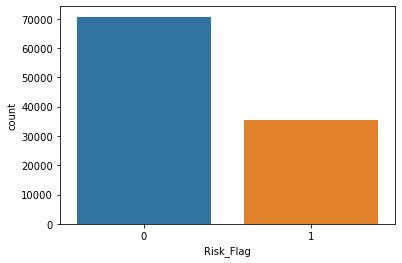

In [45]:
#TEST1
# x_train_s = x_train.to_numpy()
# y_train_s = y_train.to_numpy()
# 언더 샘플링
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
# 오버 샘플링
over_sampler = BorderlineSMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.2)
steps = [('over', over_sampler),('under', under_sampler)]
pipeline = Pipeline(steps=steps)
sample_x, sample_y = pipeline.fit_resample(x_train, y_train)

x_over1 = sample_x.join(sample_y)
x_test1 = x_test.join(y_test)

x_over1.to_csv('x_train_s1.csv', encoding='euc-kr', index = False)
x_test1.to_csv('x_test_s1.csv', encoding='euc-kr', index = False)

sns.countplot(x = sample_y)

<AxesSubplot:xlabel='Risk_Flag', ylabel='count'>

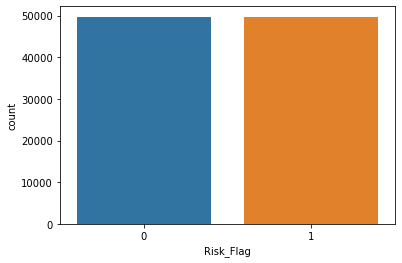

In [47]:
#TEST2
# x_train_s = x_train.to_numpy()
# y_train_s = y_train.to_numpy()
# 언더 샘플링
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
# 오버 샘플링
over_sampler = BorderlineSMOTE(random_state=42, n_jobs=-1, sampling_strategy=1)
steps = [('under', under_sampler),('over', over_sampler)]
pipeline = Pipeline(steps=steps)
sample_x, sample_y = pipeline.fit_resample(x_train, y_train)

sns.countplot(x = sample_y)

In [48]:
x_over2 = sample_x.join(sample_y)
x_test2 = x_test.join(y_test)

x_over2.to_csv('x_train_s2.csv', encoding='euc-kr', index = False)
x_test2.to_csv('x_test_s2.csv', encoding='euc-kr', index = False)

In [63]:
rtn_data2.to_csv('test_set1.csv', encoding='euc-kr', index = False)